# Text Classification using embeddings

In the last notebook, we created Word2Vec based skip-gram embeddings. Which we observed to be preserving relations to some extent using TSNE plot. This notebook we will focus on creating a deep learning classifier using embeddings as the input

## Imports

In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras import Sequential
import tensorflow.keras as keras
import torch
import numpy as np
import pickle
from tensorflow.data import Dataset
import tensorflow.data as tf_data
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from tqdm.notebook import tqdm


2023-11-05 23:04:22.180411: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-05 23:04:22.180464: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-05 23:04:22.180487: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-05 23:04:22.187392: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda")

## Loading data

In [4]:
train_df = pd.read_csv('../data/nlp-getting-started/train.csv')
test_df = pd.read_csv('../data/nlp-getting-started/test.csv')

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Loading Text encoder

In [7]:
@keras.saving.register_keras_serializable()
def standardize(input_data):
  lower_cased = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lower_cased,'[^a-z0-9#\s]', '')

with open('../data/nlp-getting-started/text_vectorizer.pckl','rb') as file:
    text_encoder = pickle.load(file)

In [8]:
text_encoder['config']['standardize'] = tf.keras.utils.serialize_keras_object(standardize,)

In [9]:
encoding_layer = layers.TextVectorization.from_config(text_encoder['config'])

2023-11-05 23:06:49.943625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-05 23:06:49.951752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-05 23:06:49.951966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
encoding_layer.set_weights(text_encoder['weights'])

In [11]:
encoding_layer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']

## Loading embedding model

In [12]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=5)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

In [13]:
word2vec = keras.models.load_model('../data/nlp-getting-started/word2vec_model/')

In [14]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]

### Creating Pytorch dataset for training & evaluation

In [91]:
class TextDataset(Dataset):
    def __init__(self, texts, encoder, weight_matrix,ids=None, labels=None,):
        super(TextDataset, self).__init__()
        self.labels = list(labels) if not labels is None else None
        self.encoder = encoder
        self.weight_matrix = weight_matrix
        self.data = self._calculate_sent_vector(list(texts))
        if ids:
            self.ids = list(ids)
        else:
            self.ids = None
    def __len__(self):
        return len(self.data)
    
    def _calculate_sent_vector(self,texts):
        encoded_texts = encoding_layer(texts)
        self.data = [torch.tensor(self.weight_matrix[encoded_text[encoded_text!=0]]) for encoded_text in encoded_texts]
        
        return 
    
    def __getitem__(self,idx):
        embeddings = self.data[idx]
        
        if not self.labels is None:
            labels = torch.tensor(self.labels[idx],dtype=torch.float) 
        else:
            labels= torch.zeros(embeddings.shape[1])
        if self.ids:
            ids = torch.tensor(self.ids[idx],dtype=torch.int64)
        else:
            ids = torch.zeros(embeddings.shape[1])
        return embeddings, labels,ids
        


**Splitting train data into train & val**

In [92]:
X_train, X_val, y_train, y_val = train_test_split(train_df['text'], train_df['target'], 
                                                    test_size=0.2, random_state=42)

In [93]:
train_dataset = TextDataset(texts=X_train, encoder=encoding_layer, weight_matrix=weights,labels=y_train)
val_dataset = TextDataset(texts=X_val, encoder=encoding_layer, weight_matrix=weights,labels=y_val)

In [94]:

def collate_fn(batch):
    embeddings, labels, ids = zip(*batch)
    embeddings = nn.utils.rnn.pad_sequence(embeddings, batch_first=True,padding_value=0)
    return embeddings, labels, ids

In [95]:
train_dataloader = DataLoader(train_dataset,batch_size=64,shuffle=True,collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,batch_size=64,shuffle=True,collate_fn=collate_fn)

In [101]:
for val in train_dataloader:
    print(val[0][0].shape)
    print(val[0][1].shape)
    print(val[0][2].shape)
    break

torch.Size([30, 128])
torch.Size([30, 128])
torch.Size([30, 128])


In [107]:
train_dataset.data[1].shape

torch.Size([15, 128])

In [97]:
 val['embedding'][3].shape

torch.Size([160, 128])

In [74]:
class TextClassifier(torch.nn.Module):
    """
        A simple Fully connected classifier with 4 linear layers with 64, 32, 8, 2 nodes.
        We extensively use Relu activation function.
    """
    def __init__(self,batch_size=64, input_shape=128, hidden_size=64):
        super(TextClassifier, self).__init__()
        self.lstm = nn.LSTM( input_shape, hidden_size, batch_first=True,dropout=0.1)
        self.linear1 = nn.Linear(in_features=hidden_size,out_features=hidden_size//2)
        self.linear2 = nn.Linear(in_features=hidden_size//2,out_features=hidden_size//4)
        self.linear3 = nn.Linear(in_features=hidden_size//4,out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out,_ = self.lstm(x)
        # As we are only doing classification of entire sequence, we don't need intermediate hidden states. We will take the last hidden state.
        out = out[:,-1,:]
        out = self.relu(self.linear1(out))
        out = self.relu(self.linear2(out))
        out = self.linear3(out)
        return out

In [75]:
text_classifier = TextClassifier()

/home/chintoo/anaconda3/envs/nlp_py10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [76]:
text_classifier.to(device)

TextClassifier(
  (lstm): LSTM(128, 64, batch_first=True, dropout=0.1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

In [77]:
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(text_classifier.parameters(), lr=0.001)

In [78]:
num_epochs = 20

In [79]:
sample['label']

tensor([1., 0., 1., 1., 1., 0., 1., 1., 1., 0.])

In [80]:
losses = list()
val_losses = list()
for epoch in tqdm(range(num_epochs)):
    running_loss = 0
    for i, sample in tqdm(enumerate(train_dataloader)):
        text_classifier.train()
        optimizer.zero_grad()
        out = text_classifier(sample['embedding'].to(device))
        loss = criterion(out,sample['label'].unsqueeze(dim=-1).to(device))
        loss.backward()
        optimizer.step()
         # Gather data and report
        running_loss += loss.item()
        if i % 30 == 29:
            losses.append(running_loss / 30) # loss per batch
            print('  batch {} loss: {}'.format(i + 1, losses[-1]))
            running_loss = 0
            text_classifier.eval()
            with torch.no_grad():
                running_val_loss = 0
                for j, val_sample in tqdm(enumerate(val_dataloader)):
                    val_out = text_classifier(val_sample['embedding'].to(device))
                    val_loss = criterion(val_out,val_sample['label'].unsqueeze(dim=-1).to(device))
                    running_val_loss += val_loss
                    if j % 10 ==9:
                        val_losses.append(running_val_loss / 10)
                        print('Val  batch {} loss: {}'.format(j + 1, val_losses[-1]))
                        running_val_loss = 0

            




        

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  batch 30 loss: 0.7159068485101064


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6964178085327148
Val  batch 20 loss: 0.699861466884613
  batch 60 loss: 0.6844627459843954


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6893200278282166
Val  batch 20 loss: 0.6754363179206848
  batch 90 loss: 0.6878438711166381


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6841453313827515
Val  batch 20 loss: 0.6827797293663025


0it [00:00, ?it/s]

  batch 30 loss: 0.6881763299306234


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6773262619972229
Val  batch 20 loss: 0.6875079870223999
  batch 60 loss: 0.6803050835927328


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6833773255348206
Val  batch 20 loss: 0.6821616888046265
  batch 90 loss: 0.6834939499696095


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6841130256652832
Val  batch 20 loss: 0.6827611327171326


0it [00:00, ?it/s]

  batch 30 loss: 0.6857918441295624


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6841113567352295
Val  batch 20 loss: 0.6845139861106873
  batch 60 loss: 0.6838220854600271


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6883358359336853
Val  batch 20 loss: 0.6730571985244751
  batch 90 loss: 0.6815560420354208


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6808925271034241
Val  batch 20 loss: 0.6848871111869812


0it [00:00, ?it/s]

  batch 30 loss: 0.6833143333594004


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6845785975456238
Val  batch 20 loss: 0.6818801760673523
  batch 60 loss: 0.6849670112133026


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6857320666313171
Val  batch 20 loss: 0.6817909479141235
  batch 90 loss: 0.6817480047543844


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6778927445411682
Val  batch 20 loss: 0.6873937249183655


0it [00:00, ?it/s]

  batch 30 loss: 0.6823884467283885


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6819376945495605
Val  batch 20 loss: 0.6797799468040466
  batch 60 loss: 0.6870052834351857


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6844621896743774
Val  batch 20 loss: 0.6856885552406311
  batch 90 loss: 0.6809754570325216


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6772655844688416
Val  batch 20 loss: 0.6856772303581238


0it [00:00, ?it/s]

  batch 30 loss: 0.6831173082192739


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6810078620910645
Val  batch 20 loss: 0.6818954348564148
  batch 60 loss: 0.6827894608179729


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6803962588310242
Val  batch 20 loss: 0.6814180016517639
  batch 90 loss: 0.6857710142930349


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6849415302276611
Val  batch 20 loss: 0.6822792887687683


0it [00:00, ?it/s]

  batch 30 loss: 0.6821682492891947


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6836723685264587
Val  batch 20 loss: 0.6805553436279297
  batch 60 loss: 0.685593718290329


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6792916655540466
Val  batch 20 loss: 0.683586061000824
  batch 90 loss: 0.6834103425343832


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6846691370010376
Val  batch 20 loss: 0.6842001676559448


0it [00:00, ?it/s]

  batch 30 loss: 0.6861564556757609


0it [00:00, ?it/s]

Val  batch 10 loss: 0.683996856212616
Val  batch 20 loss: 0.6818901896476746
  batch 60 loss: 0.6808931907018025


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6838435530662537
Val  batch 20 loss: 0.6764599680900574
  batch 90 loss: 0.6854487180709838


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6884546279907227
Val  batch 20 loss: 0.6780034899711609


0it [00:00, ?it/s]

  batch 30 loss: 0.6818343102931976


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6706300377845764
Val  batch 20 loss: 0.6860651969909668
  batch 60 loss: 0.683992991844813


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6793054342269897
Val  batch 20 loss: 0.6893256902694702
  batch 90 loss: 0.6885138909022014


0it [00:00, ?it/s]

Val  batch 10 loss: 0.68852299451828
Val  batch 20 loss: 0.6792450547218323


0it [00:00, ?it/s]

  batch 30 loss: 0.686562858025233


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6855596899986267
Val  batch 20 loss: 0.6857870221138
  batch 60 loss: 0.6814982295036316


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6818784475326538
Val  batch 20 loss: 0.6836261749267578
  batch 90 loss: 0.6856514135996501


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6810736060142517
Val  batch 20 loss: 0.6825069785118103


0it [00:00, ?it/s]

  batch 30 loss: 0.6823610663414001


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6818557977676392
Val  batch 20 loss: 0.6851276755332947
  batch 60 loss: 0.6805447340011597


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6874982118606567
Val  batch 20 loss: 0.6749144196510315
  batch 90 loss: 0.6878323018550873


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6806136965751648
Val  batch 20 loss: 0.6896182894706726


0it [00:00, ?it/s]

  batch 30 loss: 0.6890020867188772


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6874949336051941
Val  batch 20 loss: 0.6827945113182068
  batch 60 loss: 0.6801314055919647


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6714469790458679
Val  batch 20 loss: 0.6944863200187683
  batch 90 loss: 0.6804878731568654


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6893270611763
Val  batch 20 loss: 0.6761026382446289


0it [00:00, ?it/s]

  batch 30 loss: 0.6849483966827392


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6919896602630615
Val  batch 20 loss: 0.6716765761375427
  batch 60 loss: 0.6855793972810109


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6776016354560852
Val  batch 20 loss: 0.6833879351615906
  batch 90 loss: 0.6808171888192495


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6823617219924927
Val  batch 20 loss: 0.6799091100692749


0it [00:00, ?it/s]

  batch 30 loss: 0.6813450853029887


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6833187341690063
Val  batch 20 loss: 0.6779810786247253
  batch 60 loss: 0.6869503200054169


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6864630579948425
Val  batch 20 loss: 0.6807569265365601
  batch 90 loss: 0.6828957875569661


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6799288988113403
Val  batch 20 loss: 0.680411696434021


0it [00:00, ?it/s]

  batch 30 loss: 0.6788393537203471


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6839632987976074
Val  batch 20 loss: 0.6803953647613525
  batch 60 loss: 0.6903504292170207


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6868862509727478
Val  batch 20 loss: 0.6851597428321838
  batch 90 loss: 0.6838170349597931


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6902274489402771
Val  batch 20 loss: 0.6748821139335632


0it [00:00, ?it/s]

  batch 30 loss: 0.6865988592306773


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6801612973213196
Val  batch 20 loss: 0.688922107219696
  batch 60 loss: 0.6828534086545308


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6828000545501709
Val  batch 20 loss: 0.6832320094108582
  batch 90 loss: 0.6822207430998485


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6783683896064758
Val  batch 20 loss: 0.6839373111724854


0it [00:00, ?it/s]

  batch 30 loss: 0.6836543560028077


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6755083203315735
Val  batch 20 loss: 0.6914650797843933
  batch 60 loss: 0.679929236570994


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6778333783149719
Val  batch 20 loss: 0.6855283975601196
  batch 90 loss: 0.6868247330188751


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6847177743911743
Val  batch 20 loss: 0.6819323301315308


0it [00:00, ?it/s]

  batch 30 loss: 0.6828076124191285


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6795939803123474
Val  batch 20 loss: 0.6846002340316772
  batch 60 loss: 0.6867840687433878


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6806401610374451
Val  batch 20 loss: 0.6809829473495483
  batch 90 loss: 0.6815475126107534


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6841701865196228
Val  batch 20 loss: 0.6781636476516724


0it [00:00, ?it/s]

  batch 30 loss: 0.6831485629081726


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6691513657569885
Val  batch 20 loss: 0.6950448155403137
  batch 60 loss: 0.68358616232872


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6788865923881531
Val  batch 20 loss: 0.684532880783081
  batch 90 loss: 0.6854210337003072


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6801644563674927
Val  batch 20 loss: 0.6841263771057129


0it [00:00, ?it/s]

  batch 30 loss: 0.6841348131497701


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6814537644386292
Val  batch 20 loss: 0.6805673241615295
  batch 60 loss: 0.6878527363141378


0it [00:00, ?it/s]

Val  batch 10 loss: 0.685951828956604
Val  batch 20 loss: 0.686576783657074
  batch 90 loss: 0.6786956648031871


0it [00:00, ?it/s]

Val  batch 10 loss: 0.6799134612083435
Val  batch 20 loss: 0.6858105063438416


In [81]:
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline 


### Training loss

<Axes: >

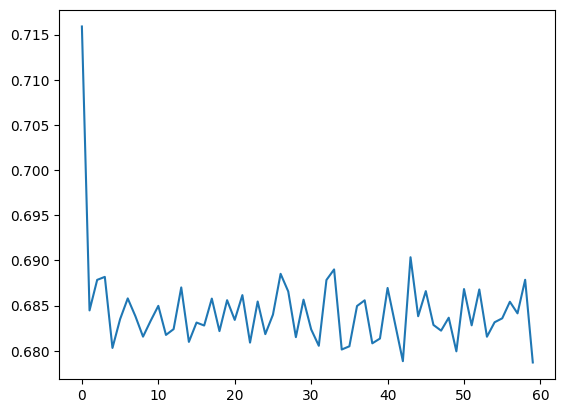

In [82]:
sns.lineplot(losses)

### Validation loss

<Axes: >

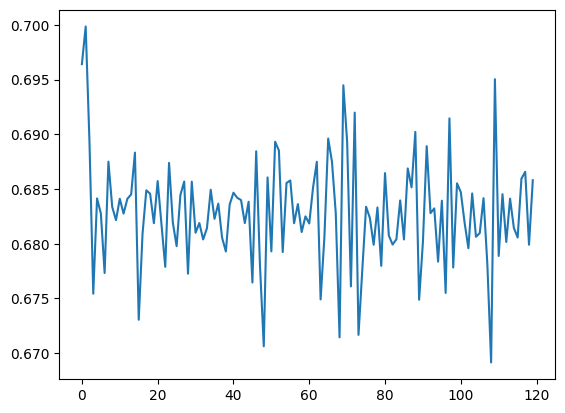

In [83]:
sns.lineplot([x.item() for x in val_losses])

***Looks like our losses are saturated mostly***

In [84]:
val_outs = list()
val_labels = list()
text_classifier.eval()
with torch.no_grad():
    for val_sample in val_dataloader:
        outs = text_classifier(val_sample['embedding'].to(device))
        val_labels.extend([x.item() for x in val_sample['label']])
        val_outs.extend([1 if x.item() >= 0.5 else 0 for x in F.sigmoid(outs).squeeze()])
        

In [85]:
val_sample['label']

tensor([0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.])

In [86]:
from sklearn.metrics import classification_report

In [88]:
print(classification_report(y_pred=val_outs, y_true=val_labels))

              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       874
         1.0       0.00      0.00      0.00       649

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.57      0.42      1523



/home/chintoo/anaconda3/envs/nlp_py10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chintoo/anaconda3/envs/nlp_py10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chintoo/anaconda3/envs/nlp_py10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [104]:
torch.save(text_classifier.state_dict(),'../data/nlp-getting-started/dl_classifier_skip_gram.bin')

In [120]:
test_dataset = TextDataset(test_df['text'], encoding_layer, weights, test_df['id'])

In [121]:
test_dataloader = DataLoader(test_dataset,batch_size=64)

In [122]:
test_outs = list()
test_ids = list()
text_classifier.eval()
with torch.no_grad():
    for test_sample in test_dataloader:
        outs = text_classifier(test_sample['embedding'].to(device))
        test_outs.extend([1 if x.item() >= 0.5 else 0 for x in F.sigmoid(outs).squeeze()])
        test_ids.extend([x.item() for x in test_sample['ids']])
        

In [123]:
submission_outs = pd.DataFrame()

In [124]:
submission_outs['id'] = test_ids

In [125]:
submission_outs['target'] = test_outs

In [128]:
submission_outs.to_csv('../data/nlp-getting-started/skip_gram_submission.csv',index=False)

In [127]:
pd.read_csv("../data/nlp-getting-started/sample_submission.csv")

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0
